In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time
from IPython import display

In [ ]:
! gdown 107_IEWAjcflF0kAACs6jWlBKjfQdZazq
! unzip Captcha-Unannotated-Dataset.zip
! mv Unannotated-Dataset Dataset

Found 10000 files belonging to 1 classes.

============== SAMPLE IMAGE ==============



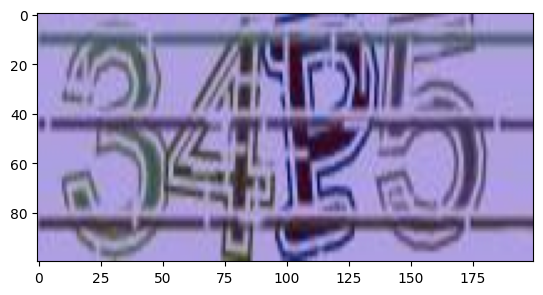

In [9]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory = "./Dataset",
    labels = None,
    shuffle = False,
    batch_size = 128,
    image_size = (100, 200) # (height, width)
)
dataset = dataset.map(lambda x: x / 255)

print("\n============== SAMPLE IMAGE ==============\n")
img, = dataset.take(1)
plt.imshow(img[0]);

In [10]:
def Encoder():
    model = tf.keras.Sequential()

    model.add(
        tf.keras.layers.Conv2D(
            32,
            (4, 4),
            strides = (1, 1),
            padding = "same",
            input_shape = [100, 200, 3],
            name = "Encoder_Conv2D_1"
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    assert model.output_shape == (None, 100, 200, 32)

    model.add(
        tf.keras.layers.Conv2D(
            64,
            (4, 4),
            strides = (2, 2),
            padding = "same",
            name = "Encoder_Conv2D_2"
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    assert model.output_shape == (None, 50, 100, 64)

    model.add(
        tf.keras.layers.Conv2D(
            64,
            (4, 4),
            strides = (2, 2),
            padding = "same",
            name = "Encoder_Conv2D_3"
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    assert model.output_shape == (None, 25, 50, 64)

    model.add(tf.keras.layers.Flatten())
    model.add(
      tf.keras.layers.Dense(
          250,
          name = "Encoder_Dense_Final"
      )
    )

    return model

In [11]:
def Decoder():
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(
            25 * 50 * 64,
            use_bias = False,
            input_shape = (250,),
            name = "Decoder_Dense_Start"
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((25, 50, 64)))
    assert model.output_shape == (None, 25, 50, 64)

    model.add(
        tf.keras.layers.Conv2DTranspose(
            64,
            (4, 4),
            strides = (1, 1),
            padding = "same",
            use_bias = False,
            name = "Decoder_Conv2DT_1"
        )
    )
    assert model.output_shape == (None, 25, 50, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(
        tf.keras.layers.Conv2DTranspose(
            32,
            (4, 4),
            strides = (2, 2),
            padding = "same",
            use_bias = False,
            name = "Decoder_Conv2DT_2"
        )
    )
    assert model.output_shape == (None, 50, 100, 32)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(
        tf.keras.layers.Conv2DTranspose(
            3,
            (4, 4),
            strides = (2, 2),
            padding = "same",
            use_bias = False,
            activation = "sigmoid",
            name = "Decoder_Conv2DT_3"
        )
    )
    assert model.output_shape == (None, 100, 200, 3)

    return model

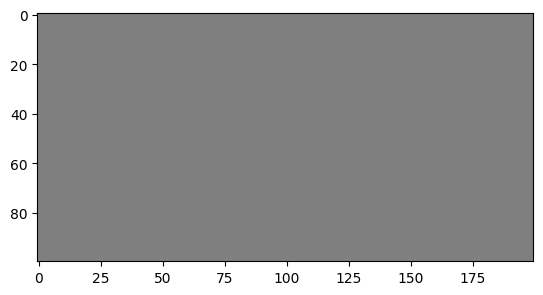

In [12]:
encoder = Encoder()
decoder = Decoder()

img, = dataset.take(1)
latent = encoder(img, training = False)
gen = decoder(latent, training = False)
plt.imshow(gen[0]);

In [13]:
optimizer = tf.keras.optimizers.legacy.Adam(0.0004)

In [14]:
def encoderDecoderLoss(y, y_pred):
    return tf.keras.backend.mean(
        tf.keras.backend.square(y - y_pred),
        axis = [1, 2, 3]
    )

In [15]:
def trainStep(images):
    with tf.GradientTape() as encoderTape, tf.GradientTape() as decoderTape:
        latent = encoder(images, training = True)
        gen = decoder(latent, training = True)
        loss = encoderDecoderLoss(images, gen)
        print(f"Loss: {tf.keras.backend.mean(loss)}")

        encoderGradients = encoderTape.gradient(
            loss,
            encoder.trainable_variables
        )
        decoderGradients = decoderTape.gradient(
            loss,
            decoder.trainable_variables
        )

        optimizer.apply_gradients(
            zip(encoderGradients, encoder.trainable_variables)
        )
        optimizer.apply_gradients(
            zip(decoderGradients, decoder.trainable_variables)
        )
        return loss

In [16]:
def train(dataset, epochs):
  for epoch in range(epochs):
    tic = time()
    for batch in dataset:
      trainStep(batch)
    toc = time()
    print(f"Epoch {epoch + 1} time: {toc - tic}s")

In [ ]:
train(dataset, 250)

4/4 [==============================] - 0s 8ms/step


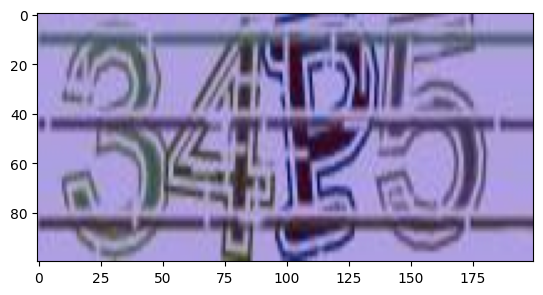

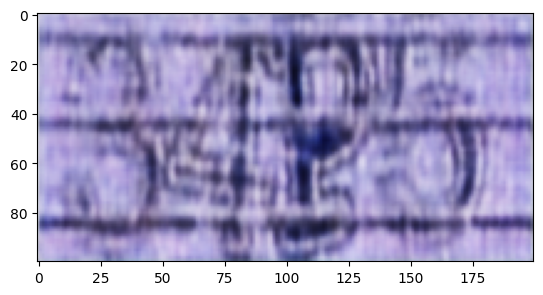

In [44]:
img_pred, = dataset.take(1)
latent_pred = encoder.predict(img_pred)
gen_pred = decoder.predict(latent_pred)

plt.figure();
plt.imshow(img_pred[0]);

plt.figure();
plt.imshow(gen_pred[0]);

In [45]:
latents = []
images = []
for batch in dataset:
  latents.extend(encoder.predict(batch))
  images.extend(batch)

1/1 [==============================] - 0s 20ms/step


In [46]:
print(f"Latent Variables Size: {len(latents)} x {len(latents[5])}")
print(f"Images Size: {len(images)} x {images[5].shape}")

Latent Variables Size: 10000 x 250
Images Size: 10000 x (100, 200, 3)


In [47]:
filePaths = [filePath.numpy().decode("utf-8") for filePath in tf.data.Dataset.list_files("./Dataset/*", shuffle = False)]

In [48]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters = 12,
    random_state = 0,
    n_init = "auto"
).fit(latents)

In [49]:
clusters = {}
for i, label in enumerate(kmeans.labels_):
  if(label in clusters.keys()):
    clusters[label].append(
        filePaths[i].replace("Dataset", "Unannotated-Dataset")
    )
  else:
    clusters[label] = [
        filePaths[i].replace("Dataset", "Unannotated-Dataset")
    ]

In [50]:
with open("clusters.txt", mode = "a") as f:
  for key, vals in clusters.items():
    f.write(str(key))
    f.write("\n")
    for val in vals:
      f.write(val + ",")
    f.write("\n")

In [51]:
encoder.save("./Models/ClusterEncoder")
decoder.save("./Models/ClusterDecoder")

In [52]:
! zip -r ClusterAutoEncoderModels.zip Models

  adding: Models/ (stored 0%)
  adding: Models/ClusterEncoder/ (stored 0%)
  adding: Models/ClusterEncoder/variables/ (stored 0%)
  adding: Models/ClusterEncoder/variables/variables.index (deflated 62%)
  adding: Models/ClusterEncoder/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: Models/ClusterEncoder/fingerprint.pb (stored 0%)
  adding: Models/ClusterEncoder/assets/ (stored 0%)
  adding: Models/ClusterEncoder/keras_metadata.pb (deflated 93%)
  adding: Models/ClusterEncoder/saved_model.pb (deflated 89%)
  adding: Models/ClusterDecoder/ (stored 0%)
  adding: Models/ClusterDecoder/variables/ (stored 0%)
  adding: Models/ClusterDecoder/variables/variables.index (deflated 59%)
  adding: Models/ClusterDecoder/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: Models/ClusterDecoder/fingerprint.pb (stored 0%)
  adding: Models/ClusterDecoder/assets/ (stored 0%)
  adding: Models/ClusterDecoder/keras_metadata.pb (deflated 93%)
  adding: Models/ClusterDecoder/saved_